# Introduction

The specific task we are trying to solve is image classification. We will be using a very commong dataset called CIFAR-10 that has 60,000 images separated into 10 classes. The classes are 
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck


In [2]:
import math 
import numpy as np
import matplotlib.pyplot as plt              # For plotting
import seaborn as sns                        # For styling plots
import torch                                 # Overall PyTorch import
import torch.nn as nn                        # For specifying neural networks
import torch.nn.functional as F              # For common functions
import torch.optim as optim                  # For optimizizing model parameters
import torchvision.datasets as datasets      # To download data
import torchvision.transforms as transforms  # For pre-processing data
import torchvision.utils as utils
sns.set()

Then we define some constants that will be used throughout the program.

In [3]:
INPUT_SIZE    = 3 * 32 * 32   # An image has 32 x 32 pixels each with Red/Green/Blue values. 
NUM_CLASSES   = 10            # The number of output classes. In this case, from 0 to 9
NUM_EPOCHS    = 20            # The number of times we loop over the whole dataset during training
BATCH_SIZE    = 100           # The size of input data took for one iteration of an epoch
LEARNING_RATE = 1e-3          # The speed of convergence
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
# We do a small amount of standardization on the image. 
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, 
                            transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Visualizing the Data 

In [5]:

dataiter = iter(test_loader)
images_batch, labels_batch = dataiter.next()
print('size of images batch', images_batch.shape)
print('size of labels', labels_batch.shape)


size of images batch torch.Size([100, 3, 32, 32])
size of labels torch.Size([100])


Now we display a few of the images along with their labels. 

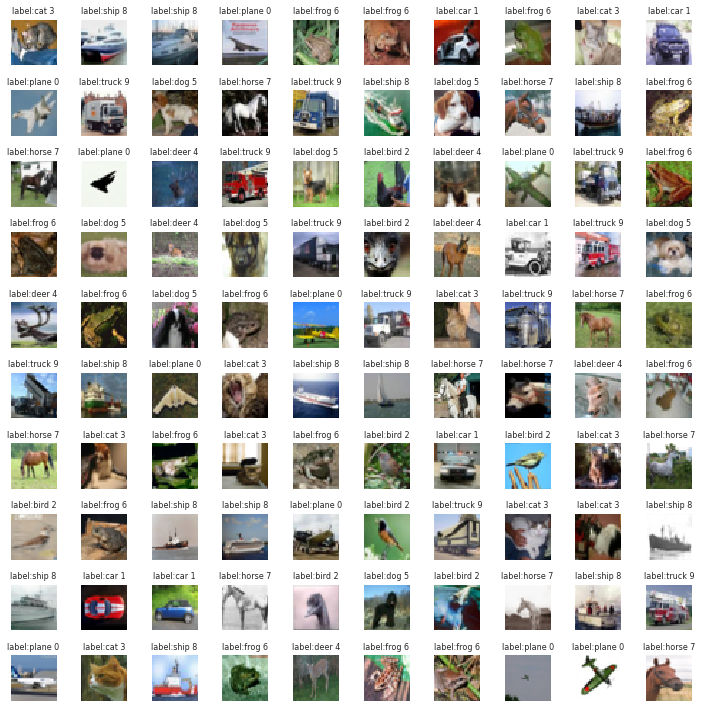

In [6]:
def imshow(imgs, labels):
    imgs = imgs / 2 + 0.5     # unnormalize
    npimgs = imgs.numpy()[:100]
    fig, ax = plt.subplots(10,10, figsize=(10, 10))
    for i,img in enumerate(npimgs):
        ax[i//10, i%10].imshow(img.transpose(1,2,0), interpolation='nearest')
        ax[i//10, i%10].set_title('label:{} {}'.format(classes[labels[i]], labels[i]), fontsize=8)
        ax[i//10, i%10].set_axis_off()  
    fig.tight_layout(h_pad=1, w_pad=1)
    plt.show()
imshow(images_batch, labels_batch)


In [7]:
def train(net, train_loader, test_loader, 
          num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, 
          compute_accs=True):
    """
    This function trains the given network on the training data for the given number of epochs. 
    If compute_accs is true, evaluates the train and test accuracy of the network at the end of 
    each epoch.

    Args:
        net: The neural network to train
        train_loader, test_loader: The pytorch dataset loaders for the trainst and testset
        num_epochs: The number of times to loop over the batches in train_loader
        learning_rate: The learning rate for the optimizer
        compute_accs: A bool flag for whether or not this function should compute the train and test
                      accuracies at the end of each epoch. This feature is useful for visualizing
                      how the model is learning, but slows down training time.
    Returns:
        The train and test accuracies if compute_accs is True, None otherwise
    """
    # First initialize the criterion (loss function) and the optimizer 
    # (algorithm like gradient descent). Here we use a common loss function for multi-class 
    # classification called the Cross Entropy Loss and the popular Adam algorithm for gradient descent.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    train_accs = []
    test_accs = []

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):   

            # If you are using a GPU, speed up computation by moving values to the GPU
            if torch.cuda.is_available( ):
                net = net.cuda()
                images = images.cuda()
                labels = labels.cuda()

    
            optimizer.zero_grad()               # Reset gradient for next computation
            outputs = net(images)               # Forward pass: compute the output class given a image
            loss = criterion(outputs, labels)   # Compute loss: difference between the pred and true 
            loss.backward()                     # Backward pass: compute the weight
            optimizer.step()                    # Optimizer: update the weights of hidden nodes

            if (i + 1) % 100 == 0:  # Print every 100 batches                              
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
        #TODO: use the accuracy function below to compute the train_acc and test_acc
        # and append them to train_accs and test_accs
        if compute_accs:
            train_acc = accuracy(net, train_loader)#TODO
            test_acc = accuracy(net, test_loader)#TODO 
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Accuracy {100 * train_acc:.2f}%, Test Accuracy {100 * test_acc:.2f}%')
    
    if compute_accs:
        return train_accs, test_accs
    else: 
        return None


def accuracy(net, data_loader):
    """
    For a given data_loader, evaluate the model on the dataset and compute its classification 
    accuracy. 

    Args:
        net: The neural network to train
        data_loader: A dataset loader for some dataset.
    Returns:
        The classificiation accuracy of the model on this dataset.
    """
    correct = 0
    total = 0
    for images, labels in data_loader:
        if  torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        outputs = net(images)                           # Make predictions
        _, predicted = torch.max(outputs.data, 1)       # Choose class with highest scores
        total += labels.size(0)                         # Increment the total count
        correct += (predicted == labels).sum().item()   # Increment the correct count
        
    return correct / total
    

def plot_history(histories):
    """
    Given a series of training/test accuracies from training, plots them to visualize learning.

    Args:
        histories: A list of dictionaries storing information about each model trained. 
                   Each dictionary should have the keys:
                        * name: The model name
                        * train_accs: A list of train accuracies 
                        * test_accs: A list of test accuracies.
    """
    plt.figure(figsize=(16,10))
    epochs = list(range(1, len(histories[0]['train_accs']) + 1))
    for model_history in histories:
      val = plt.plot(epochs, model_history['test_accs'],
                     '--', label=model_history['name'] + ' Test')
      plt.plot(epochs, model_history['train_accs'], color=val[0].get_color(),
               label=model_history['name'] + ' Train')
  
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1,max(epochs)])

# Training a CNN model, to accurately classify images  

==== Training ====
Epoch [1/25], Step [100/196], Loss: 0.9238
Epoch [1/25], Train Accuracy 75.67%, Test Accuracy 73.25%
Epoch [2/25], Step [100/196], Loss: 0.6022
Epoch [2/25], Train Accuracy 84.47%, Test Accuracy 79.91%
Epoch [3/25], Step [100/196], Loss: 0.4748
Epoch [3/25], Train Accuracy 88.81%, Test Accuracy 81.88%
Epoch [4/25], Step [100/196], Loss: 0.3024
Epoch [4/25], Train Accuracy 93.23%, Test Accuracy 84.46%
Epoch [5/25], Step [100/196], Loss: 0.2241
Epoch [5/25], Train Accuracy 95.73%, Test Accuracy 84.98%
Epoch [6/25], Step [100/196], Loss: 0.0829
Epoch [6/25], Train Accuracy 97.79%, Test Accuracy 85.41%
Epoch [7/25], Step [100/196], Loss: 0.0431
Epoch [7/25], Train Accuracy 99.17%, Test Accuracy 86.13%
Epoch [8/25], Step [100/196], Loss: 0.0264
Epoch [8/25], Train Accuracy 99.79%, Test Accuracy 87.19%
Epoch [9/25], Step [100/196], Loss: 0.0131
Epoch [9/25], Train Accuracy 99.93%, Test Accuracy 87.26%
Epoch [10/25], Step [100/196], Loss: 0.0053
Epoch [10/25], Train Accurac

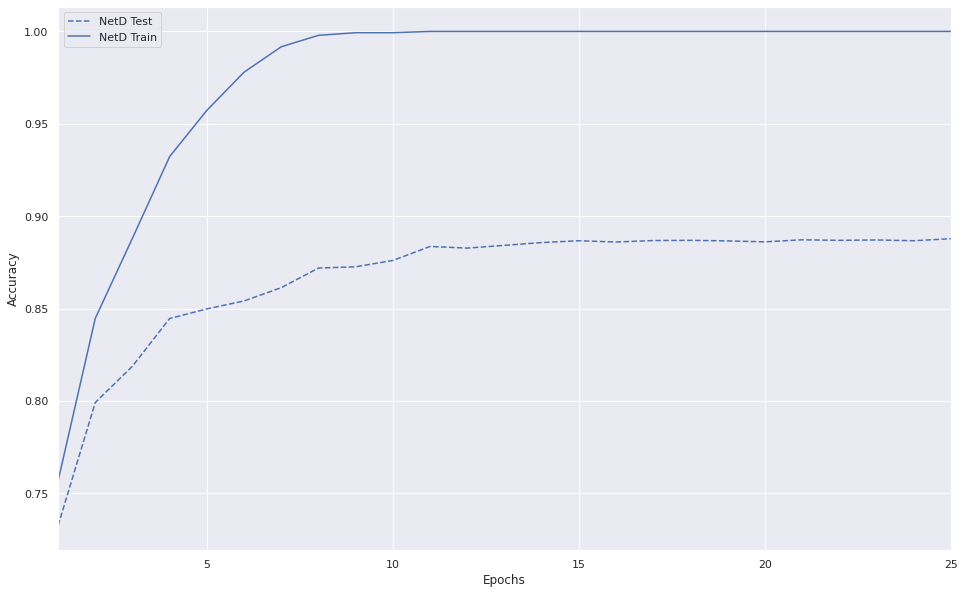

In [11]:

BATCH_SIZE = 256 
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class NetD(nn.Module):
    def __init__(self):
        super(NetD, self).__init__()
        #TODO

#----------------------------------------1------------------------------------------1

        # Create Convolutional Layer 1 
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding = (1,1))
        self.norm = nn.BatchNorm2d(64)


#----------------------------------------2-----------------------------------------2       
        # Create Convolutional Layer 2
        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3 , padding = (1,1))
        self.norm2 = nn.BatchNorm2d(128)
        # create max pool layer 2 
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)


#-----------------------------------------3-------------------------------------------3
        # Create convulation layer 3 
        self.conv_layer3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding = (1,1))
        # batch normalization 
        self.norm3 = nn.BatchNorm2d(128)

#-----------------------------------------4------------------------------------------4 
        # Create convulation layer 4
        self.conv_layer4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding = (1,1))
        # batch normalization 
        self.norm4 = nn.BatchNorm2d(256)
        # create max pool layer 4 
        # self.max_pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)

#------------------------------------------5------------------------------------------5
        # Create convulation layer 
        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding = (1,1))
        # batch normalization 
        self.norm5 = nn.BatchNorm2d(512)
        # create max pool layer
        # self.max_pool5 = nn.MaxPool2d(kernel_size = 2, stride = 2)

#------------------------------------------6------------------------------------------6        
        # Create convulation layer 
        self.conv_layer6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding = (1,1))
        # batch normalization 
        self.norm6 = nn.BatchNorm2d(512)
        # create max pool layer
        self.max_pool6 = nn.MaxPool2d(kernel_size = 4, stride = 4)

        #first fully connected layer 
        self.fc1 = nn.Linear(512,10)



    def forward(self, x):
        #TODO
        
        
        #LAYER 1
        # convulation layer 1 
        x = self.conv_layer1(x)
        x = self.norm(x)
        # activation function 
        x = F.relu(x)
        
        #LAYER 2
        # convulation layer 2 
        x = self.conv_layer2(x)
        x = self.norm2(x)
        # activation function 
        x = F.relu(x)
        # pooling layer 
        x = self.max_pool2(x)

        #LAYER 3 
        # convulation layer 3 
        x = self.conv_layer3(x)
        x = self.norm3(x)
        # activation function 
        x = F.relu(x)
        
        #LAYER 4
        # convolution layer 4 
        x = self.conv_layer4(x)
        x = self.norm4(x)
        # activation function 
        x = F.relu(x)
        # pooling layer 
        x = self.max_pool2(x)

        #LAYER 5
        x = self.conv_layer5(x)
        x = self.norm5(x)
        # activation function 
        x = F.relu(x)
        # pooling layer 
        x = self.max_pool2(x)
        # x = self.dropout(x)

        
        #LAYER 6
        x = self.conv_layer6(x)
        x = self.norm6(x)
        # activation function 
        x = F.relu(x)
        # pooling layer 
        x = self.max_pool6(x)

        
        x = torch.flatten(x, 1)
        #fully connected layer 1 
        x = self.fc1(x)
       
        return x  


net = NetD()
histories = []

print(f'==== Training ====')
train_history, test_history = train(net, train_loader, test_loader, 
                                    num_epochs=25, 
                                    learning_rate=.001, 
                                    compute_accs=True)
histories.append({
        'name': 'NetD', 
        'train_accs': train_history, 
        'test_accs': test_history
}),
plot_history(histories)